In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install keras

In [14]:
from google.colab import files
uploaded = files.upload()

Saving Stock_pre.csv to Stock_pre (1).csv


In [31]:
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('Stock_pre.csv')
features_to_scale = [

    "Vol_10", "Mom_10",
    "Vol_20", "Mom_20",
    "Vol_60", "Mom_60"
]

# Create scaler
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
df.head()

,Date,Stock,Open,High,Low,Close,Volume,LogReturn,Vol_10,Mom_10,Vol_20,Mom_20,Vol_60,Mom_60
0,2018-03-26,0,449.361557,457.370477,445.154061,450.027100,1133255,0.002653,-2.241284,0.994652,-2.848957,1.092296,-0.764435,0.804569
1,2018-03-27,0,456.823877,462.912100,450.920930,454.172575,2267331,0.009169,-2.351156,1.373527,-2.739801,1.250634,-0.728941,0.959738
2,2018-03-28,0,448.856032,457.469435,445.422329,452.418693,9297241,-0.003869,-2.568103,0.805986,-2.601056,1.126659,-0.733179,0.813368
3,2018-03-29,0,448.006484,453.820609,443.166714,451.739078,3970433,-0.001503,-2.462398,0.641659,-2.610772,1.134674,-1.111567,0.527143
4,2018-03-30,0,456.364975,454.629745,448.341851,453.659884,6428751,0.004243,-2.453405,0.658366,-2.728291,1.019654,-1.112128,0.605163


In [37]:
features_to_scale = [
    "LogReturn",
    "Vol_10", "Mom_10",
    "Vol_20", "Mom_20",
    "Vol_60", "Mom_60"
]
def create_sequences(data,features,window_size,target_shift):
  X,y = [],[]
  for stock in data['Stock'].unique():
    stock_data = data[data['Stock'] == stock]
    feature_matrix = stock_data[features].values
    target_vector = stock_data['LogReturn'].values
    for i in range(len(stock_data) - window_size - target_shift):
      X.append(feature_matrix[i:i+window_size])
      y.append(target_vector[i+window_size+target_shift])
  return np.array(X),np.array(y)
X,y = create_sequences(df,features_to_scale,60,1)
print(X.shape,y.shape)

(56450, 60, 7) (56450,)


In [38]:
split_idx = int(0.8 * len(X))

X_trainval = X[:split_idx]
y_trainval = y[:split_idx]

X_test = X[split_idx:]
y_test = y[split_idx:]

val_idx = int(0.8 * len(X_trainval))
X_train = X_trainval[:val_idx]
y_train = y_trainval[:val_idx]
X_val = X_trainval[val_idx:]
y_val = y_trainval[val_idx:]

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import Huber

# Define model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(60, 7)),
    Dropout(0.2),
    LSTM(32),
    Dense(1)   # Predict next log return
])

model.compile(
    optimizer='adam',
    loss=Huber()
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [41]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 46s 75ms/step - loss: 6.8126e-04 - val_loss: 5.4449e-05
Epoch 2/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - loss: 6.3336e-05 - val_loss: 5.5848e-05
Epoch 3/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 80s 74ms/step - loss: 5.7053e-05 - val_loss: 5.1608e-05
Epoch 4/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - loss: 5.5178e-05 - val_loss: 5.4073e-05
Epoch 5/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - loss: 5.4970e-05 - val_loss: 5.8596e-05
Epoch 6/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 85s 79ms/step - loss: 5.4364e-05 - val_loss: 5.1781e-05
Epoch 7/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - loss: 5.2803e-05 - val_loss: 5.1939e-05
Epoch 8/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 81s 76ms/step - loss: 5.2657e-05 - val_loss: 5.2088e-05


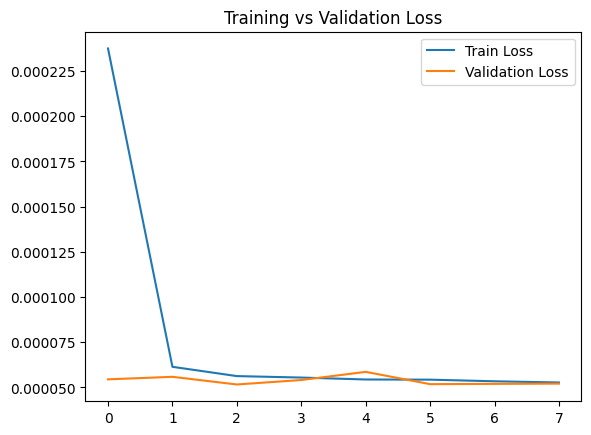

In [42]:

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [43]:
y_pred = model.predict(X_test)

353/353 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step


In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")


MSE: 0.0001
MAE: 0.0083


In [47]:
model.save("log_return_lstm_model.h5")


In [48]:
from tensorflow.keras.models import load_model
model = load_model("log_return_lstm_model.h5", custom_objects={'Huber': Huber()})

In [49]:
import joblib
joblib.dump(scaler, "scaler.pkl")

# Load later
scaler = joblib.load("scaler.pkl")
